In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import torch
import torchvision
from torchvision import transforms as T
import torchvision.transforms as transforms
from PIL import Image, ImageFont, ImageDraw
import numpy as np
import pandas as pd
import os
import json
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.model_selection import train_test_split
import ast

In [ ]:
import os
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

In [ ]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 905.3/905.3 kB 19.4 MB/s eta 0:00:00


# pre-processing

## part1

In [ ]:
file_1="/content/gdrive/MyDrive/image_processing/part1/annotations"
columns_1=["file","name","x1","y1","x2","y2"]
part1_data = pd.DataFrame(columns=columns_1)#左上與右下的點columns=["file","name","x1","y1","x2","y2"]
for filename in os.listdir(file_1):
 if filename.endswith('.json'):
    file_path = os.path.join(file_1, filename)

    # 讀取 JSON 檔案
    with open(file_path, 'r', encoding='utf-8') as file:
        data = json.load(file)

    # 將 JSON 轉換為 DataFrame
    temp_df = pd.json_normalize(data)
    temp_df_2=pd.DataFrame([[filename,temp_df["name"].iloc[0],temp_df["bbox"].iloc[0][0],temp_df["bbox"].iloc[0][1],temp_df["bbox"].iloc[0][2],temp_df["bbox"].iloc[0][3]]],columns=columns_1)
    part1_data = pd.concat([part1_data,temp_df_2], ignore_index=True)

# 輸出結果
print(part1_data)
# 可選：將結果存成 CSV
part1_data.to_csv('/content/gdrive/MyDrive/image_processing/part1/annotations.xlsx', index=False)

                         file      name   x1    y1    x2    y2
0           14820061-AP0.json  Scaphoid  450   628   589   790
1           14820061-LA0.json  Scaphoid  564   501   805   658
2           14527846-OB0.json  Scaphoid  526   743   687   881
3           15564664-LA0.json  Scaphoid  471   709   664   864
4    15027564 R 17M LAT0.json  Scaphoid  737   856   969  1002
..                        ...       ...  ...   ...   ...   ...
292         08927753-AP0.json  Scaphoid  869  1055  1019  1184
293   09057427 L 75F AP0.json  Scaphoid  688   932   816  1081
294  08890780 L 24M LAT0.json  Scaphoid  724   815   941   962
295        08368654-LAT0.json  Scaphoid  496   879   737  1031
296  20126737 L 33 F AP0.json  Scaphoid  643   858   777  1005

[297 rows x 6 columns]


##part2

In [ ]:
file_2="/content/gdrive/MyDrive/image_processing/part2/annotations"
columns_2=["file","name","fracture","bbox"] #fracture骨折
part2_data=pd.DataFrame(columns=columns_2)
for filename in os.listdir(file_2):
 if filename.endswith('.json'):
    file_path = os.path.join(file_2, filename)
    fracture_check=0
    # 讀取 JSON 檔案
    with open(file_path, 'r', encoding='utf-8') as file:
        data = json.load(file)

    # 將 JSON 轉換為 DataFrame
    temp_df = pd.json_normalize(data)
    if(temp_df["name"].iloc[0]=="Fracture"):
      fracture_check=1
    else:
      fracture_check=0
    temp_df_2=pd.DataFrame([[filename,temp_df["name"].iloc[0],fracture_check,temp_df["bbox"].iloc[0]]],columns=columns_2)
    part2_data = pd.concat([part2_data,temp_df_2], ignore_index=True)

# 輸出結果
print(part2_data)

# 可選：將結果存成 CSV
part2_data.to_csv('/content/gdrive/MyDrive/image_processing/part2/annotations.xlsx', index=False)

                         file      name fracture  \
0           14653976-LA0.json  Fracture        1   
1    15027564 R 17M LAT0.json      None        0   
2           14636068-LA0.json  Fracture        1   
3           13414417-AP0.json      None        0   
4    14239462 L 57M LAT0.json      None        0   
..                        ...       ...      ...   
292         08280455-LA0.json  Fracture        1   
293  07632414 L 35M LAT0.json      None        0   
294   07968496 L 20M AP0.json      None        0   
295         08442301-AP0.json  Fracture        1   
296         08368654-AP0.json  Fracture        1   

                                                  bbox  
0    [[121.83406829833984, 39.66765213012695], [148...  
1                                                 None  
2    [[93.45440673828125, 22.096473693847656], [167...  
3                                                 None  
4                                                 None  
..                               

In [ ]:
img_file_2="/content/gdrive/MyDrive/image_processing/part2/images"
img_file_1="/content/gdrive/MyDrive/image_processing/part1/images"

file_2_csv="/content/gdrive/MyDrive/image_processing/part2/annotations.csv"
part2_data_csv=pd.read_csv(file_2_csv)
part2_data=pd.DataFrame(part2_data_csv.values,columns=["file","name","fracture","bbox"])

file_1_csv="/content/gdrive/MyDrive/image_processing/part1/annotations.csv"
part1_data_csv=pd.read_csv(file_1_csv)
part1_data=pd.DataFrame(part1_data_csv.values,columns=["file","name","x1","y1","x2","y2"])

for i in range(len(part2_data)):
  filename=part2_data["file"].iloc[i]
  image_filename=filename.split(".")[0]+".jpg"
  image=mpimg.imread(os.path.join(img_file_1, image_filename))
  index=part1_data[part1_data["file"] == filename].index[0]
  bone_image=image[int(part1_data["y1"].iloc[index]):int(part1_data["y2"].iloc[index]),int(part1_data["x1"].iloc[index]):int(part1_data["x2"].iloc[index])]
  if bone_image.size == 0:
      print(f"Warning: bone_image for {filename} is empty!")
      continue  # 跳過這張影像的處理
  print(image_filename)
  #plt.imshow(bone_image, cmap='gray')
  #plt.show()
  cv2.imwrite(os.path.join(img_file_2, image_filename), bone_image)

14653976-LA0.jpg
15027564 R 17M LAT0.jpg
14636068-LA0.jpg
13414417-AP0.jpg
14239462 L 57M LAT0.jpg
15027564 R 17M AP0.jpg
15895620-OB0.jpg
14962613 L 36F LAT0.jpg
14962613 L 36F AP0.jpg
14527846-LA0.jpg
15926103 R 41M AP0.jpg
14653976-SC0.jpg
15564664-LA0.jpg
13805669-LA0.jpg
14820061-AP0.jpg
15564664-AP0.jpg
13805669-SC0.jpg
14820061-LA0.jpg
15895620-LA0.jpg
14636068-AP0.jpg
14527846-OB0.jpg
14239462 L 57M AP0.jpg
18060182-LA0.jpg
18060182-AP0.jpg
18292796-AP0.jpg
16179379-LA0.jpg
17873653 L 23M LAT0.jpg
15926103 R 41M LAT0.jpg
17247340 L 32F AP0.jpg
17441223 R 27F LAT0.jpg
17530562 R 60F LAT0.jpg
18096532 L 18M LAT0.jpg
16133052-LA0.jpg
16828252-AP20.jpg
17441223 L 27F LAT0.jpg
16642586 L 27 F AP0.jpg
16061744-AP0.jpg
17696455-LAT0.jpg
17964244-LA0.jpg
16179379-AP0.jpg
17781310 L 22M LAT0.jpg
17494507 L 25M LAT0.jpg
18292796-LA0.jpg
17972018 R 21M AP0.jpg
16133052-AP0.jpg
182504260 L 28F AP0.jpg
17441223 R 27F AP0.jpg
17972018 R 21M LAT0.jpg
16645616-SC0.jpg
16828252-LA0.jpg
18096532

In [ ]:
import math, os, json
def order_points(points):
  # 计算四个顶点的中心点坐标
  center_x = sum([p[0] for p in points]) / 4
  center_y = sum([p[1] for p in points]) / 4
  # 计算每个点相对于中心点的角度，按逆时针方向排序，确保点的顺序一致
  points = sorted(points, key=lambda p: math.atan2(p[1] - center_y, p[0] - center_x), reverse=True)
  return [points[0], points[1], points[2], points[3]] #右上、右下、左下、左上

def convert_json_to_yolo11(unique_img,output_folder,image_folder):
  for filename in unique_img:
    image_filename=filename.split(".")[0]+".jpg"
    img=Image.open(os.path.join(image_folder, image_filename))
    img_width, img_height = img.size
    img.save(os.path.join(output_folder, image_filename), format="JPEG")

    yolo_lines = []
    class_index =part2_data[part2_data["file"]==filename]["fracture"].iloc[0]
    if(class_index==1):
      points_str=part2_data[part2_data["file"]==filename]["bbox"].iloc[0]
      if isinstance(points_str, str):
        points = ast.literal_eval(points_str)  # string->list
      if(len(points)==4):
        ordered_points = order_points(points) # 使用order_points函数对顶点进行顺序排列
        normalized_points = [[round(x / img_width, 6), round(y / img_height, 6)] for x, y in ordered_points] #normalization
        yolo_line = [class_index-1] + [coord for point in normalized_points for coord in point]
        yolo_lines.append(" ".join(map(str, yolo_line)))
        if yolo_lines:
          txt_filename = os.path.splitext(filename)[0] + ".txt"
          output_path = os.path.join(output_folder, txt_filename)
          with open(output_path, 'w') as out_file:
            out_file.write("\n".join(yolo_lines))
    else:
      txt_filename = os.path.splitext(filename)[0] + ".txt"
      output_path = os.path.join(output_folder, txt_filename)
      with open(output_path, 'w') as out_file:
            out_file.write("")

In [ ]:
data_2='/content/gdrive/MyDrive/image_processing/part2/annotations.xlsx'
images_2='/content/gdrive/MyDrive/image_processing/part2/images'
part2_data_csv=pd.read_csv(data_2)
part2_data=pd.DataFrame(part2_data_csv.values,columns=["file","name","fracture","bbox"])
unique_img=part2_data["file"].unique()
output_folder = "/content/gdrive/MyDrive/image_processing/part2/data"
convert_json_to_yolo11(unique_img,output_folder,images_2)

In [ ]:
print(len(os.listdir('/content/gdrive/MyDrive/image_processing/part2/data/')))

594


# part1

## train


In [ ]:
data_1='/content/gdrive/MyDrive/image_processing/part1/annotations.xlsx'
images_1='/content/gdrive/MyDrive/image_processing/part1/images'
part1_data_csv=pd.read_csv(data_1)
part1_data=pd.DataFrame(part1_data_csv.values,columns=["file","name","x1","y1","x2","y2"])
unique_img=part1_data["file"].unique()

In [ ]:
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.ColorJitter(brightness=(0.8, 1.2), contrast=(0.8, 1.5)), ## 亮度和對比度調整
    transforms.RandomHorizontalFlip(p=0.5),#水平翻轉
    transforms.RandomRotation(degrees=30),#隨機旋轉 -30° 到 30° 之間
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

In [ ]:
class CustData(torch.utils.data.Dataset):
  def __init__(self,df,unique_img,indices):
     self.df=df
     self.unique_img=unique_img
     self.indices=indices
     self.transform = transform
  def __len__(self):
    return len(self.indices)
  def __getitem__(self,idx):
    img_name=self.unique_img[self.indices[idx]]
    boxes=self.df[self.df.file==img_name].values[:,2:].astype(dtype=np.float32)
    boxes=torch.as_tensor(boxes,dtype=torch.float32)
    image_filename=img_name.split(".")[0]+".jpg"
    img=Image.open(os.path.join(images_1, image_filename))
    labels=torch.ones((boxes.shape[0],),dtype=torch.int64)
    target={}
    target["boxes"]=boxes
    target["labels"]=labels
    return T.ToTensor()(img),target

In [ ]:
train_inds,val_inds=train_test_split(np.arange(len(unique_img)),test_size=0.2,random_state=42)

In [ ]:
def custom_collate(data):
  return data

In [ ]:
train_DataLoader=torch.utils.data.DataLoader(CustData(part1_data,unique_img,train_inds),
                  batch_size=10,
                  shuffle=True,
                  collate_fn=custom_collate,
                  pin_memory=True if torch.cuda.is_available() else False)

val_DataLoader=torch.utils.data.DataLoader(CustData(part1_data,unique_img,train_inds),
                  batch_size=10,
                  shuffle=True,
                  collate_fn=custom_collate,
                  pin_memory=True if torch.cuda.is_available() else False)

In [ ]:
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
model=torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained= True)
num_classes=2 #加上背景
in_features=model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor=FastRCNNPredictor(in_features,num_classes)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:01<00:00, 150MB/s]


In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)#0.0001
num_epochs = 10

In [ ]:
def compute_iou(pred_boxes, target_boxes):
    """Compute IoU for two sets of bounding boxes."""
    # Ensure tensors are on the same device
    pred_boxes = pred_boxes.cpu().detach()
    target_boxes = target_boxes.cpu().detach()

    # Calculate intersection
    inter_min = torch.max(pred_boxes[:, None, :2], target_boxes[:, :2])  # Top-left corners
    inter_max = torch.min(pred_boxes[:, None, 2:], target_boxes[:, 2:])  # Bottom-right corners
    inter_wh = (inter_max - inter_min).clamp(min=0)  # Intersection width and height
    inter_area = inter_wh[:, :, 0] * inter_wh[:, :, 1]  # Intersection area

    # Calculate union
    pred_area = (pred_boxes[:, 2] - pred_boxes[:, 0]) * (pred_boxes[:, 3] - pred_boxes[:, 1])
    target_area = (target_boxes[:, 2] - target_boxes[:, 0]) * (target_boxes[:, 3] - target_boxes[:, 1])
    union_area = pred_area[:, None] + target_area - inter_area

    # IoU
    iou = inter_area / union_area
    max_iou_per_target = iou.max(dim=0)[0]  # 每个目标框的最大 IoU
    return max_iou_per_target.mean().item()  # 返回平均最大 IoU

New best model saved with Val iou: 0.8243
Epoch 1, Train Loss: 0.0240
Val IoU: 0.8243
New best model saved with Val iou: 0.8644
Epoch 2, Train Loss: 0.0138
Val IoU: 0.8644
New best model saved with Val iou: 0.8919
Epoch 3, Train Loss: 0.0091
Val IoU: 0.8919
New best model saved with Val iou: 0.9050
Epoch 4, Train Loss: 0.0073
Val IoU: 0.9050
New best model saved with Val iou: 0.9192
Epoch 5, Train Loss: 0.0060
Val IoU: 0.9192
New best model saved with Val iou: 0.9261
Epoch 6, Train Loss: 0.0053
Val IoU: 0.9261
Epoch 7, Train Loss: 0.0047
Val IoU: 0.9255
New best model saved with Val iou: 0.9312
Epoch 8, Train Loss: 0.0041
Val IoU: 0.9312
New best model saved with Val iou: 0.9447
Epoch 9, Train Loss: 0.0039
Val IoU: 0.9447
Epoch 10, Train Loss: 0.0039
Val IoU: 0.9369


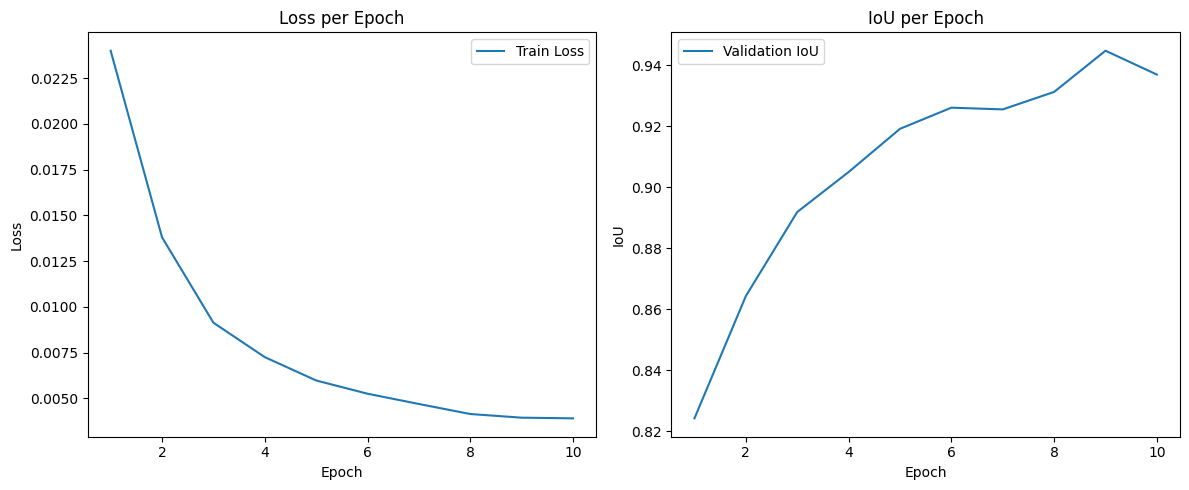

In [ ]:
import matplotlib.pyplot as plt

model.to(device)

train_losses = []
val_losses = []
train_ious = []
val_ious = []

best_iou = 0.0
model_path="/content/gdrive/MyDrive/image_processing/part1/ver3.pth"


for epoch in range(num_epochs):
    # Training phase
    model.train()
    epoch_train_loss = 0.0
    epoch_train_iou = 0.0
    train_total_samples = 0
    for data in train_DataLoader:
        images = []
        targets = []

        for d in data:
            images.append(d[0].to(device))
            targ = {
                "boxes": d[1]["boxes"].to(device),
                "labels": d[1]["labels"].to(device)
            }
            targets.append(targ)

        # Forward pass
        loss_dict = model(images, targets)  # Compute loss
        losses = sum(loss for loss in loss_dict.values())

        # Backward pass
        epoch_train_loss += losses.item()
        train_total_samples += len(data)
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

    train_losses.append(epoch_train_loss / train_total_samples)

    # Validation phase
    model.eval()
    epoch_val_loss = 0.0
    epoch_val_iou = 0.0
    val_total_samples = 0
    with torch.no_grad():
        for data in val_DataLoader:
            images = []
            targets = []

            for d in data:
                images.append(d[0].to(device))
                targ = {
                    "boxes": d[1]["boxes"].to(device),
                    "labels": d[1]["labels"].to(device)
                }
                targets.append(targ)

            # Forward pass to get predictions
            outputs = model(images)

            # Calculate IoU for each image
            for i, output in enumerate(outputs):
                pred_boxes = output["boxes"]  # Predicted boxes from the model
                target_boxes = targets[i]["boxes"]  # Ground-truth boxes

                # Compute IoU between predicted and target boxes
                if pred_boxes.size(0) > 0 and target_boxes.size(0) > 0:
                    ious = compute_iou(pred_boxes, target_boxes)
                    max_iou_per_target = ious
                    epoch_val_iou += max_iou_per_target # 累加 IoU
                    val_total_samples += 1
                else:
                    # 若无预测或无目标，IoU 计为 0
                    epoch_val_iou += 0.0
                    val_total_samples += 1

    val_ious.append(epoch_val_iou / val_total_samples)
    if val_ious[-1] > best_iou:
      best_iou = val_ious[-1]
      torch.save(model, model_path)# 儲存模型參數
      print(f"New best model saved with Val iou: {best_iou:.4f}")

    # Print losses and IoU
    print(f"Epoch {epoch + 1}, Train Loss: {train_losses[-1]:.4f}")
    print(f"Val IoU: {val_ious[-1]:.4f}")

# Plotting loss and IoU
epochs = range(1, num_epochs + 1)

plt.figure(figsize=(12, 5))

# Plot losses
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label="Train Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss per Epoch")
plt.legend()

# Plot IoUs
plt.subplot(1, 2, 2)
plt.plot(epochs, val_ious, label="Validation IoU")
plt.xlabel("Epoch")
plt.ylabel("IoU")
plt.title("IoU per Epoch")
plt.legend()

plt.tight_layout()
plt.show()

## test

15564664-LA0.jpg


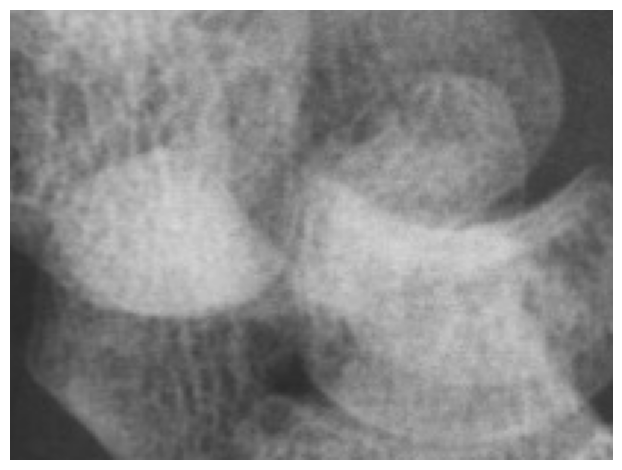

13805669-SC0.jpg


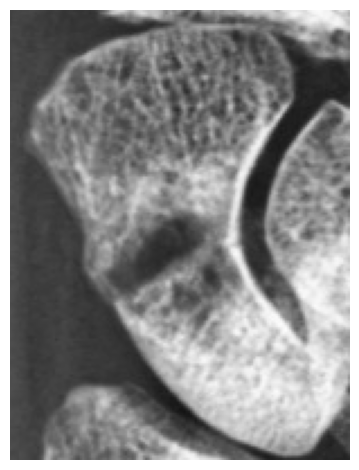

15926103 R 41M AP0.jpg


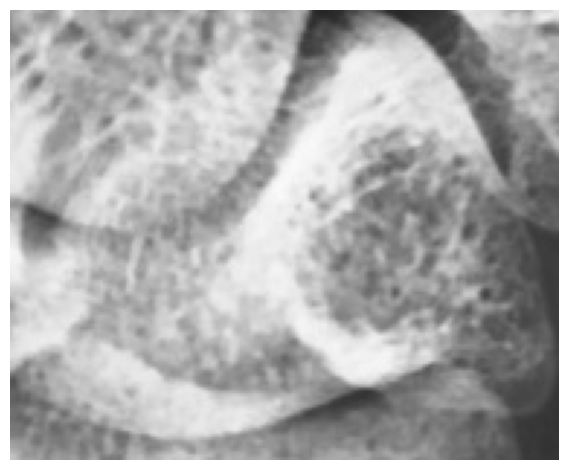

16645616-SC0.jpg


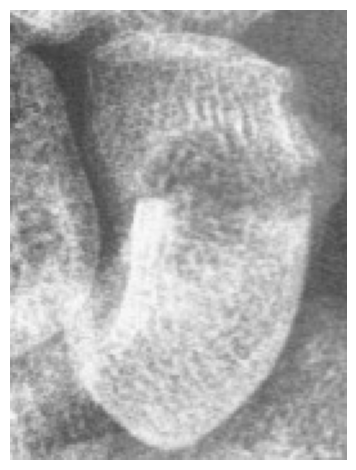

03192499 L 27M LAT0.jpg


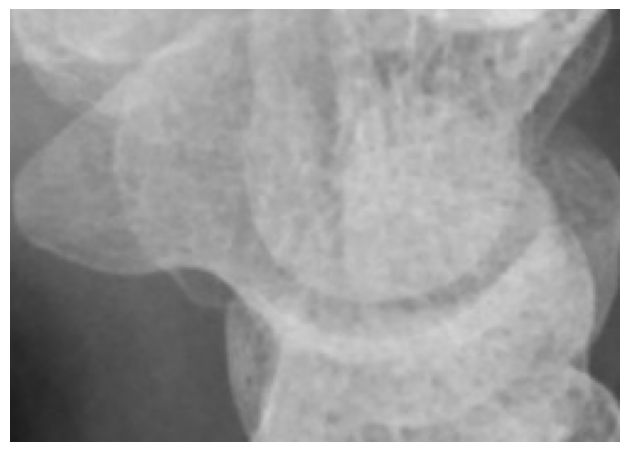

16608087-SC0.jpg


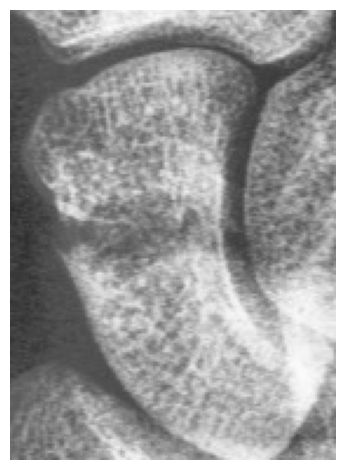

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model1=torch.load("./model1.pth", map_location=device)
model1.eval()  # 設置模型為評估模式
file_path = "/content/gdrive/MyDrive/image_processing/part1/images/"
index=0
transform = T.ToTensor()  # 轉換圖片為 Tensor 格式
for i in os.listdir(file_path):
  print(i)
  image=Image.open(os.path.join(file_path,i)).convert("RGB")
  image_tensor = transform(image).unsqueeze(0).to(device)  # 增加 batch 維度

  # 獲取模型輸出
  outputs = model1(image_tensor)
  print(outputs)
  output = outputs[0]
  if(len(output["boxes"]))>0:
    pred_boxes = output["boxes"][0].cpu().detach().numpy()  # [x_min, y_min, x_max, y_max]
    part2_img = image.crop((pred_boxes[0], pred_boxes[1], pred_boxes[2], pred_boxes[3]))
    #pred_boxes = output["boxes"][0]
    #part2_img=image[pred_boxes[0]:pred_boxes[3],pred_boxes[1]:pred_boxes[2]]
    fig, ax = plt.subplots()# 設置繪圖區域
    ax.imshow(part2_img)# 顯示圖片
    ax.axis("off")  # 去除軸標籤
    fig.canvas.manager.set_window_title('part1_image')
    plt.tight_layout()# 使佈局緊湊
    plt.show()  # 顯示圖片
    index=index+1
    if(index>5):
      break

# part2

## train

### 分割dataset

In [ ]:

import fnmatch
import random
import shutil
def split_train_val(src_dir,split_ratio=0.7):

  # Get a list of all the images in the directory
  images = [file for file in os.listdir(src_dir) if fnmatch.fnmatch(file, '*.jpg')]
  # Shuffle the list of images
  random.shuffle(images)

  # Split the list of images into training and validation sets
  train_size = int(split_ratio * len(images))
  train_images = images[:train_size]
  val_images = images[train_size:]

  # Create the training and validation directories
  train_dir = os.path.join(src_dir, 'train')
  val_dir = os.path.join(src_dir, 'val')
  os.makedirs(train_dir, exist_ok=True)
  os.makedirs(val_dir, exist_ok=True)

  # Copy the training images and labels to the training directory
  for image in train_images:
    if image.endswith('.jpg'):
      shutil.copyfile(src_dir+'/'+image, train_dir+'/'+ image)
      label_file = image.replace('.jpg', '.txt')
      shutil.copyfile(src_dir+'/'+label_file, train_dir+'/'+label_file)

  # Copy the validation images and labels to the validation directory
  for image in val_images:
    if image.endswith('.jpg'):
      shutil.copyfile(src_dir+'/'+image, val_dir+'/'+image)
      label_file = image.replace('.jpg', '.txt')
      shutil.copyfile(src_dir+'/'+label_file, val_dir+'/'+label_file)

In [ ]:
split_train_val('/content/gdrive/MyDrive/image_processing/part2/data/', split_ratio=0.8)

In [ ]:
print(len(os.listdir('/content/gdrive/MyDrive/image_processing/part2/data/val/')))
print(len(os.listdir('/content/gdrive/MyDrive/image_processing/part2/data/train/')))

120
474


### 建立yami

In [ ]:
import yaml
def creat_yaml(train_dir,val_dir,nc,names,yaml_file_path):
  # Create the .yaml files for training and validation
  data_config = {
    'train': train_dir,
    'val': val_dir,
    'nc': nc,
    'names': names
  }

  with open(yaml_file_path, 'w') as f:
    yaml.dump(data_config, f)

In [ ]:
train_dir='/content/gdrive/MyDrive/image_processing/part2/data/train'
val_dir='/content/gdrive/MyDrive/image_processing/part2/data/val'
nc=1
names={0:"fracture"}
yaml_file_path='/content/gdrive/MyDrive/image_processing/part2/model.yaml'
creat_yaml(train_dir,val_dir,nc,names,yaml_file_path)

### 導入yolo

In [ ]:
from ultralytics import YOLO

# Load a model
model = YOLO("yolo11m-obb.yaml")  # build a new model from YAML
model = YOLO("yolo11m-obb.pt")  # load a pretrained model (recommended for training)
model = YOLO("yolo11m-obb.yaml").load("yolo11m.pt")  # build from YAML and transfer weights

# Train the model
results = model.train(data="/content/gdrive/MyDrive/image_processing/part2/model.yaml",
    epochs=200,
    lr0=0.0001,
    batch=3,
    fliplr=0.8,
    hsv_v=0.5,
    optimizer="AdamW")
#ver2:epochs=50，batch=10
#ver3:epochs=200,batch=5
#ver4:增加增強fliplr=0.5、hsv_h=0.015、hsv_s=0.7、hsv_v=0.4
#ver5:batch=3，fliplr=0.8、hsv_v=0.5，移除(hsv_h=0.05、hsv_s=0.8)
#ver6 YOLO11m-obb，epochs=200

100%|██████████| 40.5M/40.5M [00:00<00:00, 102MB/s]


100%|██████████| 38.8M/38.8M [00:00<00:00, 95.9MB/s]


Transferred 649/691 items from pretrained weights
Ultralytics 8.3.58 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=obb, mode=train, model=yolo11m-obb.yaml, data=/content/gdrive/MyDrive/image_processing/part2/model.yaml, epochs=200, time=None, patience=100, batch=3, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train4, exist_ok=False, pretrained=yolo11m.pt, optimizer=AdamW, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, sa

train: Scanning /content/gdrive/MyDrive/image_processing/part2/data/train.cache... 237 images, 127 backgrounds, 0 corrupt: 100%|██████████| 237/237 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))



val: Scanning /content/gdrive/MyDrive/image_processing/part2/data/val.cache... 60 images, 27 backgrounds, 0 corrupt: 100%|██████████| 60/60 [00:00<?, ?it/s]


Plotting labels to runs/obb/train4/labels.jpg... 
optimizer: AdamW(lr=0.0001, momentum=0.937) with parameter groups 112 weight(decay=0.0), 122 weight(decay=0.0004921875), 121 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/obb/train4
Starting training for 200 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/200      2.27G      2.228      4.625      3.492          4        640: 100%|██████████| 79/79 [00:16<00:00,  4.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:03<00:00,  5.98it/s]

                   all         60         33    0.00793      0.182    0.00762    0.00239



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/200      2.07G      2.215      3.712       3.53          4        640: 100%|██████████| 79/79 [00:18<00:00,  4.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:02<00:00,  9.45it/s]

                   all         60         33     0.0192      0.788     0.0374    0.00815



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/200      2.07G      2.224      3.504      3.415          2        640: 100%|██████████| 79/79 [00:18<00:00,  4.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:01<00:00, 14.73it/s]

                   all         60         33     0.0212      0.606      0.157      0.026



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/200      2.07G      2.018      3.556      3.061          0        640: 100%|██████████| 79/79 [00:15<00:00,  5.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:01<00:00, 14.69it/s]

                   all         60         33     0.0263      0.333     0.0668     0.0101



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/200      2.07G      2.158      3.356      3.203          7        640: 100%|██████████| 79/79 [00:15<00:00,  5.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:01<00:00, 14.68it/s]

                   all         60         33      0.134      0.212      0.191      0.031



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/200      2.07G      2.141      3.136      3.283          2        640: 100%|██████████| 79/79 [00:15<00:00,  5.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:01<00:00, 14.93it/s]

                   all         60         33     0.0415      0.758       0.14     0.0432



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/200      2.07G      2.055      3.236      3.085          6        640: 100%|██████████| 79/79 [00:14<00:00,  5.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:01<00:00, 11.23it/s]

                   all         60         33     0.0627      0.727      0.193     0.0629



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/200      2.07G      2.137      3.043      3.196          3        640: 100%|██████████| 79/79 [00:15<00:00,  5.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:01<00:00, 14.96it/s]

                   all         60         33       0.26      0.245      0.309       0.11



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/200      2.07G      2.106      2.953      3.132          2        640: 100%|██████████| 79/79 [00:15<00:00,  5.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:01<00:00, 14.95it/s]

                   all         60         33      0.228      0.303       0.29     0.0882



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/200      2.07G      2.016      3.026      3.085          2        640: 100%|██████████| 79/79 [00:15<00:00,  5.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:01<00:00, 15.25it/s]

                   all         60         33      0.373      0.121      0.266     0.0726



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/200      2.07G      2.082      2.816       3.23          3        640: 100%|██████████| 79/79 [00:15<00:00,  5.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:01<00:00, 15.11it/s]

                   all         60         33      0.339      0.515      0.331      0.101



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/200      2.07G      2.107        2.9      3.274          2        640: 100%|██████████| 79/79 [00:15<00:00,  5.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:01<00:00, 15.09it/s]

                   all         60         33      0.635      0.152      0.316      0.122



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/200      2.07G      2.006      2.769      3.135          2        640: 100%|██████████| 79/79 [00:17<00:00,  4.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:01<00:00, 14.83it/s]

                   all         60         33      0.365      0.314      0.253     0.0855



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/200      2.07G      2.032      2.686       3.18          1        640: 100%|██████████| 79/79 [00:15<00:00,  4.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:01<00:00, 14.89it/s]

                   all         60         33      0.314      0.526      0.328     0.0979



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/200      2.07G      1.996      2.952      3.092          2        640: 100%|██████████| 79/79 [00:15<00:00,  5.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:01<00:00, 15.00it/s]

                   all         60         33      0.238      0.397      0.303      0.106



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/200      2.07G      2.048      2.861      3.244          2        640: 100%|██████████| 79/79 [00:15<00:00,  5.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:01<00:00, 14.84it/s]

                   all         60         33      0.396      0.182      0.296      0.113



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/200      2.07G      1.824      2.695      3.059          5        640: 100%|██████████| 79/79 [00:15<00:00,  5.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:01<00:00, 14.39it/s]

                   all         60         33      0.311      0.301      0.286      0.122



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/200      2.07G      2.052      2.694      3.153          4        640: 100%|██████████| 79/79 [00:15<00:00,  5.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:01<00:00, 14.93it/s]

                   all         60         33      0.339      0.404      0.346      0.117



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/200      2.07G      1.937      2.558      3.078          4        640: 100%|██████████| 79/79 [00:15<00:00,  5.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:01<00:00, 14.99it/s]

                   all         60         33      0.321      0.242      0.318      0.123



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/200      2.07G      1.972      2.524      3.082          6        640: 100%|██████████| 79/79 [00:14<00:00,  5.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:02<00:00,  9.77it/s]

                   all         60         33      0.416      0.515      0.318      0.108



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/200      2.07G      1.892      2.583      3.073          3        640: 100%|██████████| 79/79 [00:14<00:00,  5.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:01<00:00, 10.59it/s]

                   all         60         33      0.354      0.424      0.348     0.0977



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/200      2.07G      2.051      2.591      3.172          1        640: 100%|██████████| 79/79 [00:15<00:00,  5.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:01<00:00, 14.49it/s]

                   all         60         33      0.363      0.364      0.372      0.097



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/200      2.07G      1.901      2.503       3.03          4        640: 100%|██████████| 79/79 [00:15<00:00,  5.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:01<00:00, 14.64it/s]

                   all         60         33      0.436      0.399      0.374       0.11



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/200      2.07G      1.892      2.365      3.072          2        640: 100%|██████████| 79/79 [00:16<00:00,  4.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:01<00:00, 14.92it/s]

                   all         60         33      0.371      0.455      0.342      0.109



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/200      2.07G      1.831      2.376      2.958          6        640: 100%|██████████| 79/79 [00:16<00:00,  4.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:02<00:00,  9.31it/s]

                   all         60         33      0.422      0.333      0.318      0.107



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/200      2.07G      1.998      2.158      3.139          4        640: 100%|██████████| 79/79 [00:15<00:00,  5.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:01<00:00, 14.67it/s]

                   all         60         33      0.411      0.338      0.328      0.119



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/200      2.07G      1.764      2.294      2.869          0        640: 100%|██████████| 79/79 [00:15<00:00,  5.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:01<00:00, 15.05it/s]

                   all         60         33      0.333      0.212      0.252     0.0989



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/200      2.07G      1.942      2.309      3.072          4        640: 100%|██████████| 79/79 [00:15<00:00,  5.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:01<00:00, 14.84it/s]

                   all         60         33      0.384      0.212      0.276     0.0994



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/200      2.07G      1.903      2.269      2.982          2        640: 100%|██████████| 79/79 [00:15<00:00,  5.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:01<00:00, 14.97it/s]

                   all         60         33      0.496      0.242      0.347      0.101



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/200      2.07G       1.75      2.115      2.856          0        640: 100%|██████████| 79/79 [00:15<00:00,  5.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:01<00:00, 15.03it/s]

                   all         60         33      0.335      0.212      0.268     0.0897



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/200      2.07G      1.945      2.161        3.1          2        640: 100%|██████████| 79/79 [00:15<00:00,  5.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:01<00:00, 13.21it/s]

                   all         60         33      0.334      0.333      0.325      0.123



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/200      2.07G      1.877       1.99      3.129          5        640: 100%|██████████| 79/79 [00:15<00:00,  5.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:01<00:00, 10.84it/s]

                   all         60         33      0.475      0.333        0.4      0.108



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/200      2.07G      1.853      2.097      2.853          1        640: 100%|██████████| 79/79 [00:14<00:00,  5.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:01<00:00, 10.44it/s]

                   all         60         33      0.349      0.303      0.295     0.0986



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/200      2.07G      1.898      2.121      3.034          1        640: 100%|██████████| 79/79 [00:14<00:00,  5.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:02<00:00,  9.09it/s]

                   all         60         33      0.343      0.459      0.316     0.0951



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/200      2.07G      1.775      2.109      2.807          2        640: 100%|██████████| 79/79 [00:14<00:00,  5.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:01<00:00, 10.47it/s]


                   all         60         33      0.377      0.394      0.327     0.0891

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/200      2.07G       1.76      2.003      3.014          4        640: 100%|██████████| 79/79 [00:15<00:00,  5.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:01<00:00, 12.06it/s]

                   all         60         33      0.335      0.303      0.333      0.101



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/200      2.07G      1.639      2.013      2.719          6        640: 100%|██████████| 79/79 [00:15<00:00,  4.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:01<00:00, 14.57it/s]

                   all         60         33      0.473      0.354      0.368      0.114



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/200      2.07G      1.896      2.122      2.994          3        640: 100%|██████████| 79/79 [00:17<00:00,  4.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:02<00:00,  9.01it/s]

                   all         60         33      0.462      0.333      0.338      0.122



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/200      2.07G      1.654      1.956       2.81          8        640: 100%|██████████| 79/79 [00:15<00:00,  5.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:01<00:00, 14.66it/s]

                   all         60         33      0.465      0.421      0.402      0.122



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/200      2.07G      1.711      2.044      2.868          3        640: 100%|██████████| 79/79 [00:15<00:00,  5.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:01<00:00, 15.33it/s]

                   all         60         33      0.629      0.242      0.334      0.137



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/200      2.07G      1.809      1.903      3.065          3        640: 100%|██████████| 79/79 [00:15<00:00,  5.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:01<00:00, 14.51it/s]

                   all         60         33      0.547      0.367      0.425      0.142



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/200      2.07G      1.655      1.862      2.928          4        640: 100%|██████████| 79/79 [00:16<00:00,  4.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:01<00:00, 14.68it/s]

                   all         60         33      0.413      0.455      0.327      0.123



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/200      2.07G      1.654      1.976      2.766          1        640: 100%|██████████| 79/79 [00:15<00:00,  4.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:01<00:00, 15.36it/s]

                   all         60         33      0.414      0.364      0.332      0.127



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/200      2.07G      1.732      2.054      2.801          3        640: 100%|██████████| 79/79 [00:16<00:00,  4.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:01<00:00, 15.15it/s]

                   all         60         33      0.379      0.333      0.349      0.127



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/200      2.07G      1.674      1.855      2.908          5        640: 100%|██████████| 79/79 [00:15<00:00,  5.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:01<00:00, 14.90it/s]

                   all         60         33      0.377      0.576      0.361      0.112



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/200      2.07G      1.568      1.911       2.72          4        640: 100%|██████████| 79/79 [00:15<00:00,  5.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:01<00:00, 15.13it/s]

                   all         60         33       0.55      0.303      0.445      0.143



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/200      2.07G      1.661       1.77      2.895          1        640: 100%|██████████| 79/79 [00:15<00:00,  4.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:01<00:00, 14.68it/s]

                   all         60         33       0.55      0.334      0.414      0.139



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/200      2.07G      1.599      1.742      2.669          2        640: 100%|██████████| 79/79 [00:15<00:00,  5.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:01<00:00, 15.12it/s]

                   all         60         33      0.623      0.364      0.461      0.145



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/200      2.07G      1.678      1.718      2.913          2        640: 100%|██████████| 79/79 [00:15<00:00,  5.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:01<00:00, 15.08it/s]

                   all         60         33      0.495      0.394      0.413      0.145



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/200      2.07G      1.799      1.769      2.941          6        640: 100%|██████████| 79/79 [00:15<00:00,  5.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:01<00:00, 14.03it/s]

                   all         60         33      0.541      0.303      0.356      0.121



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/200      2.07G      1.747      1.782      2.784          3        640: 100%|██████████| 79/79 [00:17<00:00,  4.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:01<00:00, 10.34it/s]

                   all         60         33      0.646      0.242      0.385      0.134



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/200      2.07G      1.699      1.627      2.933          5        640: 100%|██████████| 79/79 [00:14<00:00,  5.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:01<00:00, 10.17it/s]

                   all         60         33      0.594      0.333      0.405      0.156



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/200      2.07G      1.602       1.72      2.684          3        640: 100%|██████████| 79/79 [00:15<00:00,  5.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:01<00:00, 15.17it/s]

                   all         60         33      0.624      0.273      0.345      0.136



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/200      2.07G      1.557      1.714      2.616          2        640: 100%|██████████| 79/79 [00:15<00:00,  5.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:01<00:00, 14.89it/s]

                   all         60         33      0.452      0.326       0.32       0.14



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/200      2.07G      1.663      1.735      2.731          3        640: 100%|██████████| 79/79 [00:15<00:00,  5.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:01<00:00, 15.15it/s]

                   all         60         33      0.495      0.387      0.354      0.143



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/200      2.07G      1.466      1.488      2.635          2        640: 100%|██████████| 79/79 [00:15<00:00,  5.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:01<00:00, 15.06it/s]

                   all         60         33      0.402      0.394      0.314      0.119



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/200      2.07G      1.635      1.504      2.792          5        640: 100%|██████████| 79/79 [00:15<00:00,  5.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:01<00:00, 15.26it/s]

                   all         60         33      0.592      0.303      0.289      0.114



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/200      2.07G       1.41      1.537      2.453          3        640: 100%|██████████| 79/79 [00:15<00:00,  5.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:01<00:00, 15.13it/s]

                   all         60         33      0.489      0.333      0.318      0.133



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/200      2.07G      1.491      1.569      2.585          1        640: 100%|██████████| 79/79 [00:14<00:00,  5.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:01<00:00, 15.29it/s]

                   all         60         33      0.455      0.364      0.364       0.14



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/200      2.07G       1.58      1.597      2.692          6        640: 100%|██████████| 79/79 [00:15<00:00,  5.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:01<00:00, 15.47it/s]

                   all         60         33      0.685      0.329      0.375      0.149



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/200      2.07G      1.398      1.591       2.47          4        640: 100%|██████████| 79/79 [00:15<00:00,  5.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:01<00:00, 15.26it/s]

                   all         60         33      0.705      0.363      0.385      0.142



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/200      2.07G      1.501      1.594       2.75          3        640: 100%|██████████| 79/79 [00:15<00:00,  5.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:01<00:00, 15.44it/s]

                   all         60         33      0.445      0.316      0.314      0.125



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/200      2.07G      1.548      1.437      2.797          6        640: 100%|██████████| 79/79 [00:15<00:00,  5.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:01<00:00, 15.31it/s]

                   all         60         33      0.486      0.273      0.279      0.116



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/200      2.07G      1.518      1.711      2.712          2        640: 100%|██████████| 79/79 [00:17<00:00,  4.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:01<00:00, 11.02it/s]


                   all         60         33      0.336      0.303      0.222      0.123

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/200      2.07G      1.583      1.757      2.656          3        640: 100%|██████████| 79/79 [00:14<00:00,  5.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:01<00:00, 10.86it/s]

                   all         60         33      0.484      0.364      0.322      0.146



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/200      2.07G      1.442       1.57      2.538          1        640: 100%|██████████| 79/79 [00:14<00:00,  5.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:02<00:00,  9.87it/s]

                   all         60         33      0.452      0.451      0.347      0.163



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/200      2.07G      1.366      1.401      2.528          3        640: 100%|██████████| 79/79 [00:15<00:00,  4.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:01<00:00, 15.15it/s]

                   all         60         33      0.482      0.485      0.403      0.141



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/200      2.07G      1.557      1.551      2.686          1        640: 100%|██████████| 79/79 [00:15<00:00,  5.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:01<00:00, 15.12it/s]

                   all         60         33      0.448      0.455      0.353      0.138



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/200      2.07G      1.386      1.391      2.546          2        640: 100%|██████████| 79/79 [00:15<00:00,  5.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:01<00:00, 15.14it/s]

                   all         60         33      0.448      0.394      0.321      0.152



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/200      2.07G      1.561      1.482      2.745          4        640: 100%|██████████| 79/79 [00:15<00:00,  5.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:01<00:00, 14.75it/s]

                   all         60         33      0.563      0.333      0.313      0.147



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/200      2.07G      1.421       1.46      2.652          7        640: 100%|██████████| 79/79 [00:15<00:00,  5.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:01<00:00, 15.34it/s]

                   all         60         33      0.396      0.394      0.303      0.116



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/200      2.07G      1.312      1.398      2.459          1        640: 100%|██████████| 79/79 [00:16<00:00,  4.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:01<00:00, 15.20it/s]

                   all         60         33      0.455      0.394      0.309       0.12



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/200      2.07G       1.39      1.416      2.518          2        640: 100%|██████████| 79/79 [00:15<00:00,  5.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:01<00:00, 14.94it/s]

                   all         60         33      0.438      0.455      0.299      0.119



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/200      2.07G      1.392      1.388      2.564          3        640: 100%|██████████| 79/79 [00:15<00:00,  5.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:01<00:00, 15.05it/s]

                   all         60         33      0.386      0.455      0.296      0.131



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/200      2.07G       1.34      1.415      2.459          5        640: 100%|██████████| 79/79 [00:15<00:00,  5.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:01<00:00, 15.00it/s]

                   all         60         33      0.548      0.331      0.309      0.129



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/200      2.07G      1.412      1.316      2.586          1        640: 100%|██████████| 79/79 [00:15<00:00,  4.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:01<00:00, 14.99it/s]

                   all         60         33      0.428      0.364      0.303      0.129



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/200      2.07G      1.431      1.371      2.536          3        640: 100%|██████████| 79/79 [00:18<00:00,  4.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:01<00:00, 15.15it/s]

                   all         60         33      0.443      0.337      0.258      0.113



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/200      2.07G      1.478      1.371      2.579          7        640: 100%|██████████| 79/79 [00:15<00:00,  5.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:01<00:00, 14.90it/s]

                   all         60         33      0.401      0.333       0.23     0.0973



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/200      2.07G      1.359      1.353      2.509          1        640: 100%|██████████| 79/79 [00:15<00:00,  5.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:01<00:00, 15.41it/s]

                   all         60         33       0.43      0.273      0.276      0.101



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/200      2.07G      1.215      1.289      2.307          8        640: 100%|██████████| 79/79 [00:15<00:00,  5.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:01<00:00, 15.29it/s]

                   all         60         33      0.598      0.303      0.375       0.14



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/200      2.07G      1.444      1.395      2.574          7        640: 100%|██████████| 79/79 [00:15<00:00,  5.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:01<00:00, 13.79it/s]

                   all         60         33      0.554      0.394      0.392      0.152



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/200      2.07G      1.345      1.183      2.513          1        640: 100%|██████████| 79/79 [00:15<00:00,  5.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:01<00:00, 11.05it/s]

                   all         60         33      0.602      0.394      0.411      0.157



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/200      2.07G       1.31      1.341      2.315          4        640: 100%|██████████| 79/79 [00:15<00:00,  5.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:01<00:00, 11.63it/s]

                   all         60         33      0.612      0.333      0.397      0.169



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/200      2.07G      1.367      1.271      2.534          2        640: 100%|██████████| 79/79 [00:15<00:00,  5.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:01<00:00, 15.78it/s]

                   all         60         33      0.508      0.303      0.358      0.159



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/200      2.07G      1.333      1.335      2.436          4        640: 100%|██████████| 79/79 [00:15<00:00,  5.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:01<00:00, 14.88it/s]

                   all         60         33      0.476      0.303      0.311      0.143



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/200      2.07G      1.244      1.194      2.332          4        640: 100%|██████████| 79/79 [00:15<00:00,  5.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:01<00:00, 15.61it/s]

                   all         60         33      0.455      0.273       0.33      0.131



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/200      2.07G      1.346      1.264      2.354          5        640: 100%|██████████| 79/79 [00:15<00:00,  5.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:01<00:00, 15.29it/s]

                   all         60         33      0.683      0.273      0.376       0.14



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/200      2.07G      1.323      1.413      2.413          3        640: 100%|██████████| 79/79 [00:14<00:00,  5.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:01<00:00, 12.05it/s]

                   all         60         33      0.613      0.273      0.374      0.136



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/200      2.07G      1.253      1.242      2.432          2        640: 100%|██████████| 79/79 [00:14<00:00,  5.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:01<00:00, 10.96it/s]

                   all         60         33      0.541      0.273      0.332      0.132



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/200      2.07G      1.303      1.316      2.255          0        640: 100%|██████████| 79/79 [00:18<00:00,  4.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:01<00:00, 11.28it/s]

                   all         60         33      0.526      0.303       0.36       0.14



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/200      2.07G      1.358      1.338       2.38          4        640: 100%|██████████| 79/79 [00:15<00:00,  5.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:01<00:00, 11.91it/s]

                   all         60         33      0.543      0.288      0.331      0.117



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/200      2.07G      1.246      1.196      2.218          0        640: 100%|██████████| 79/79 [00:15<00:00,  5.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:01<00:00, 12.86it/s]

                   all         60         33      0.717      0.242      0.339      0.124



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/200      2.07G      1.337      1.394      2.359          1        640: 100%|██████████| 79/79 [00:15<00:00,  5.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:01<00:00, 15.33it/s]

                   all         60         33      0.637      0.273      0.332      0.148



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/200      2.07G      1.345      1.232      2.439          6        640: 100%|██████████| 79/79 [00:15<00:00,  5.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:01<00:00, 15.30it/s]

                   all         60         33      0.477      0.364      0.355      0.157



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/200      2.07G      1.228      1.199       2.27          5        640: 100%|██████████| 79/79 [00:15<00:00,  5.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:01<00:00, 15.38it/s]

                   all         60         33      0.609      0.303      0.367      0.166



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/200      2.07G       1.23       1.24      2.437          1        640: 100%|██████████| 79/79 [00:15<00:00,  5.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:01<00:00, 13.92it/s]

                   all         60         33      0.559      0.364       0.39      0.169



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/200      2.07G      1.324      1.265      2.415          4        640: 100%|██████████| 79/79 [00:15<00:00,  5.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:01<00:00, 15.42it/s]

                   all         60         33      0.533      0.346      0.414       0.18



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/200      2.07G      1.227      1.272      2.252          4        640: 100%|██████████| 79/79 [00:15<00:00,  5.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:01<00:00, 15.07it/s]

                   all         60         33      0.476      0.394      0.399      0.185



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/200      2.07G       1.29      1.247      2.426          4        640: 100%|██████████| 79/79 [00:15<00:00,  5.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:01<00:00, 14.05it/s]

                   all         60         33      0.613      0.364      0.364       0.16



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/200      2.07G      1.162      1.178      2.361          3        640: 100%|██████████| 79/79 [00:14<00:00,  5.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:01<00:00, 11.19it/s]

                   all         60         33      0.577      0.333      0.362       0.16



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    101/200      2.07G      1.212      1.133      2.289          3        640: 100%|██████████| 79/79 [00:14<00:00,  5.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:01<00:00, 10.31it/s]

                   all         60         33      0.442      0.337      0.345      0.143



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    102/200      2.07G      1.225      1.161      2.247          2        640: 100%|██████████| 79/79 [00:14<00:00,  5.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:01<00:00, 10.06it/s]

                   all         60         33      0.478      0.417      0.362      0.157



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    103/200      2.07G      1.169       1.12       2.18          3        640: 100%|██████████| 79/79 [00:17<00:00,  4.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:02<00:00,  9.14it/s]

                   all         60         33      0.408      0.394      0.364      0.154



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    104/200      2.07G      1.279      1.157      2.423          2        640: 100%|██████████| 79/79 [00:15<00:00,  5.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:01<00:00, 11.40it/s]

                   all         60         33      0.466      0.424      0.384      0.148



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    105/200      2.07G      1.358      1.251      2.424          5        640: 100%|██████████| 79/79 [00:15<00:00,  5.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:01<00:00, 13.07it/s]

                   all         60         33      0.465      0.394       0.43      0.178



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    106/200      2.07G      1.203      1.038      2.129          5        640: 100%|██████████| 79/79 [00:15<00:00,  5.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:01<00:00, 15.33it/s]

                   all         60         33      0.541      0.358      0.382      0.158



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    107/200      2.07G      1.236      1.146      2.309          2        640: 100%|██████████| 79/79 [00:15<00:00,  5.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:01<00:00, 15.46it/s]

                   all         60         33      0.519      0.333      0.331      0.142



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    108/200      2.07G      1.228      1.134      2.192          0        640: 100%|██████████| 79/79 [00:15<00:00,  5.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:01<00:00, 15.48it/s]

                   all         60         33      0.554      0.301      0.328      0.143



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    109/200      2.07G      1.179      1.164      2.189          3        640: 100%|██████████| 79/79 [00:15<00:00,  5.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:01<00:00, 14.68it/s]

                   all         60         33      0.571      0.323      0.382      0.168



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    110/200      2.07G      1.221      1.166      2.352          3        640: 100%|██████████| 79/79 [00:15<00:00,  5.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:01<00:00, 15.19it/s]

                   all         60         33      0.494      0.296      0.355      0.155



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    111/200      2.07G      1.238      1.082      2.349          4        640: 100%|██████████| 79/79 [00:15<00:00,  5.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:01<00:00, 15.56it/s]

                   all         60         33        0.5      0.364      0.368      0.174



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    112/200      2.07G      1.282      1.195      2.379          4        640: 100%|██████████| 79/79 [00:15<00:00,  5.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:01<00:00, 15.03it/s]

                   all         60         33      0.455      0.394      0.336      0.133



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    113/200      2.07G      1.223      1.142      2.329          3        640: 100%|██████████| 79/79 [00:15<00:00,  5.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:01<00:00, 15.28it/s]

                   all         60         33      0.554      0.424       0.35      0.125



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    114/200      2.07G      1.263      1.282      2.314          3        640: 100%|██████████| 79/79 [00:15<00:00,  5.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:01<00:00, 15.14it/s]

                   all         60         33      0.451      0.364      0.336      0.122



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    115/200      2.07G      1.309       1.19      2.403          4        640: 100%|██████████| 79/79 [00:15<00:00,  5.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:01<00:00, 15.39it/s]

                   all         60         33      0.585      0.299      0.361      0.114



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    116/200      2.07G      1.153      1.034      2.185          3        640: 100%|██████████| 79/79 [00:15<00:00,  5.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:01<00:00, 14.46it/s]

                   all         60         33      0.555      0.394      0.317      0.112



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    117/200      2.07G      1.216      1.153      2.276          4        640: 100%|██████████| 79/79 [00:17<00:00,  4.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:01<00:00, 15.35it/s]

                   all         60         33      0.543      0.364       0.35      0.124



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    118/200      2.07G      1.188      1.066      2.302          3        640: 100%|██████████| 79/79 [00:15<00:00,  5.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:01<00:00, 15.52it/s]

                   all         60         33       0.59      0.394      0.347       0.13



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    119/200      2.07G      1.127      1.046      2.162          2        640: 100%|██████████| 79/79 [00:15<00:00,  5.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:01<00:00, 11.88it/s]

                   all         60         33      0.528      0.272      0.257      0.123



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    120/200      2.07G      1.219      1.108       2.28          5        640: 100%|██████████| 79/79 [00:14<00:00,  5.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:01<00:00, 10.90it/s]

                   all         60         33      0.453      0.242      0.275      0.123



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    121/200      2.07G      1.174      1.052      2.185          4        640: 100%|██████████| 79/79 [00:14<00:00,  5.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:01<00:00, 10.61it/s]

                   all         60         33      0.544      0.303      0.279      0.119



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    122/200      2.07G      1.277      1.247      2.218          2        640: 100%|██████████| 79/79 [00:14<00:00,  5.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:02<00:00,  9.94it/s]

                   all         60         33      0.609      0.333      0.341      0.126



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    123/200      2.07G      1.182      1.259      2.159          1        640: 100%|██████████| 79/79 [00:14<00:00,  5.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:01<00:00, 10.54it/s]

                   all         60         33      0.659      0.333       0.37      0.142



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    124/200      2.07G      1.314      1.186      2.357          4        640: 100%|██████████| 79/79 [00:15<00:00,  5.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:01<00:00, 14.87it/s]

                   all         60         33      0.616      0.341      0.353      0.157



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    125/200      2.07G       1.11     0.9664      2.137          8        640: 100%|██████████| 79/79 [00:15<00:00,  5.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:01<00:00, 15.87it/s]

                   all         60         33      0.613      0.364      0.353      0.169



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    126/200      2.07G      1.113     0.9477      2.229          4        640: 100%|██████████| 79/79 [00:15<00:00,  5.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:01<00:00, 15.59it/s]

                   all         60         33      0.568      0.394      0.382      0.161



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    127/200      2.07G      1.157     0.9899      2.073          1        640: 100%|██████████| 79/79 [00:18<00:00,  4.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:01<00:00, 15.35it/s]

                   all         60         33      0.632      0.333      0.366      0.147



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    128/200      2.07G      1.123      1.113      2.136          5        640: 100%|██████████| 79/79 [00:15<00:00,  5.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:01<00:00, 15.33it/s]

                   all         60         33      0.515      0.303      0.351       0.13



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    129/200      2.07G      1.117      1.023      2.086          2        640: 100%|██████████| 79/79 [00:15<00:00,  5.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:01<00:00, 15.26it/s]

                   all         60         33      0.817      0.271      0.373      0.133



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    130/200      2.07G      1.225      1.073      2.307          1        640: 100%|██████████| 79/79 [00:18<00:00,  4.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:01<00:00, 12.58it/s]

                   all         60         33       0.56      0.309       0.39      0.144



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    131/200      2.07G      1.191      1.097      2.135          4        640: 100%|██████████| 79/79 [00:15<00:00,  5.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:01<00:00, 15.25it/s]

                   all         60         33      0.806      0.303      0.421      0.154



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    132/200      2.07G       1.11     0.9762      2.129          3        640: 100%|██████████| 79/79 [00:15<00:00,  5.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:01<00:00, 15.78it/s]

                   all         60         33      0.803      0.303      0.423      0.168



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    133/200      2.07G      1.221       1.12      2.212          1        640: 100%|██████████| 79/79 [00:15<00:00,  5.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:01<00:00, 14.97it/s]

                   all         60         33      0.669      0.333      0.391      0.165



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    134/200      2.07G      1.162      1.093      2.178          2        640: 100%|██████████| 79/79 [00:15<00:00,  5.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:01<00:00, 12.13it/s]

                   all         60         33      0.589      0.333      0.353      0.167



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    135/200      2.07G      1.226      1.079      2.212          3        640: 100%|██████████| 79/79 [00:14<00:00,  5.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:01<00:00, 11.29it/s]

                   all         60         33      0.473      0.303      0.311      0.156



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    136/200      2.07G      1.136      1.122       2.15          5        640: 100%|██████████| 79/79 [00:14<00:00,  5.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:01<00:00, 10.89it/s]

                   all         60         33      0.548      0.364      0.327      0.139



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    137/200      2.07G      1.116      1.023      2.129          4        640: 100%|██████████| 79/79 [00:14<00:00,  5.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:01<00:00, 11.32it/s]

                   all         60         33       0.58      0.303      0.325      0.132



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    138/200      2.07G      1.053     0.9524       2.07          1        640: 100%|██████████| 79/79 [00:14<00:00,  5.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:01<00:00, 10.88it/s]

                   all         60         33      0.619      0.303      0.334       0.14



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    139/200      2.07G      1.122      1.054      2.181          4        640: 100%|██████████| 79/79 [00:16<00:00,  4.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:03<00:00,  6.35it/s]

                   all         60         33      0.608      0.303      0.348      0.149



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    140/200      2.07G      1.089     0.9712      2.124          2        640: 100%|██████████| 79/79 [00:20<00:00,  3.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:01<00:00, 12.30it/s]

                   all         60         33      0.683      0.327      0.382      0.174



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    141/200      2.07G      1.141      1.015      2.159          1        640: 100%|██████████| 79/79 [00:15<00:00,  5.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:01<00:00, 15.23it/s]

                   all         60         33      0.539      0.364      0.376      0.148



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    142/200      2.07G      1.064      1.078      2.102          3        640: 100%|██████████| 79/79 [00:15<00:00,  5.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:01<00:00, 15.62it/s]

                   all         60         33      0.589      0.333      0.344       0.14



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    143/200      2.07G       1.11      1.004      2.143          4        640: 100%|██████████| 79/79 [00:17<00:00,  4.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:01<00:00, 15.38it/s]

                   all         60         33      0.533      0.311      0.335      0.126



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    144/200      2.07G      1.107     0.9771      2.123          3        640: 100%|██████████| 79/79 [00:15<00:00,  5.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:01<00:00, 15.62it/s]

                   all         60         33      0.504      0.333      0.295      0.119



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    145/200      2.07G      1.117     0.9616      2.213          3        640: 100%|██████████| 79/79 [00:15<00:00,  5.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:01<00:00, 14.70it/s]

                   all         60         33      0.501      0.333      0.296      0.118



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    146/200      2.07G      1.056     0.9759      2.023          2        640: 100%|██████████| 79/79 [00:14<00:00,  5.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:01<00:00, 11.70it/s]

                   all         60         33      0.496      0.333      0.334      0.133



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    147/200      2.07G      1.054      1.039       2.01          1        640: 100%|██████████| 79/79 [00:14<00:00,  5.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:01<00:00, 11.01it/s]

                   all         60         33      0.477      0.333       0.29       0.12



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    148/200      2.07G      1.059     0.9962      2.006          4        640: 100%|██████████| 79/79 [00:14<00:00,  5.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:01<00:00, 10.15it/s]

                   all         60         33      0.498      0.333      0.299      0.123



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    149/200      2.07G      1.045     0.9638      2.157          0        640: 100%|██████████| 79/79 [00:14<00:00,  5.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:01<00:00, 10.08it/s]

                   all         60         33       0.42      0.308      0.365       0.16



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    150/200      2.07G      1.181      1.095      2.129          0        640: 100%|██████████| 79/79 [00:15<00:00,  5.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:01<00:00, 14.08it/s]

                   all         60         33      0.422      0.364      0.332      0.143



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    151/200      2.07G      1.022     0.9473       2.02          3        640: 100%|██████████| 79/79 [00:15<00:00,  5.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:01<00:00, 15.36it/s]

                   all         60         33      0.525      0.424      0.355      0.137



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    152/200      2.07G     0.9678      0.878      1.944          4        640: 100%|██████████| 79/79 [00:16<00:00,  4.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:01<00:00, 15.83it/s]

                   all         60         33      0.577      0.394      0.373      0.141



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    153/200      2.07G      1.065     0.9248      2.063          2        640: 100%|██████████| 79/79 [00:15<00:00,  5.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:01<00:00, 15.35it/s]

                   all         60         33      0.581      0.364      0.365      0.143



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    154/200      2.07G      1.069      1.019      2.102          4        640: 100%|██████████| 79/79 [00:16<00:00,  4.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:01<00:00, 15.10it/s]

                   all         60         33      0.435      0.394      0.329       0.14



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    155/200      2.07G      1.043      0.974      1.993          3        640: 100%|██████████| 79/79 [00:15<00:00,  5.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:01<00:00, 15.64it/s]

                   all         60         33      0.399      0.342      0.321      0.125



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    156/200      2.07G      1.096      1.028      2.126          3        640: 100%|██████████| 79/79 [00:15<00:00,  5.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:01<00:00, 15.34it/s]

                   all         60         33      0.415      0.344      0.314      0.123



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    157/200      2.07G      1.067     0.9486      1.982          1        640: 100%|██████████| 79/79 [00:18<00:00,  4.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:01<00:00, 15.08it/s]

                   all         60         33      0.458      0.384      0.308      0.116



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    158/200      2.07G       1.05      0.967       2.01          3        640: 100%|██████████| 79/79 [00:15<00:00,  4.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:01<00:00, 15.37it/s]

                   all         60         33      0.472      0.364      0.324       0.12



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    159/200      2.07G     0.9799      0.974      1.867          4        640: 100%|██████████| 79/79 [00:15<00:00,  5.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:01<00:00, 14.93it/s]

                   all         60         33      0.513      0.319      0.305      0.118



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    160/200      2.07G      1.047     0.9624      2.009          3        640: 100%|██████████| 79/79 [00:16<00:00,  4.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:01<00:00, 15.23it/s]

                   all         60         33      0.471      0.303      0.308      0.124



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    161/200      2.07G     0.9985     0.8676      2.014          2        640: 100%|██████████| 79/79 [00:15<00:00,  5.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:01<00:00, 13.75it/s]

                   all         60         33      0.462      0.303      0.283      0.129



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    162/200      2.07G      1.068     0.9783      1.996          1        640: 100%|██████████| 79/79 [00:15<00:00,  5.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:01<00:00, 10.75it/s]

                   all         60         33      0.465      0.317      0.351      0.144



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    163/200      2.07G      1.073      1.005      2.123          4        640: 100%|██████████| 79/79 [00:15<00:00,  5.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:01<00:00, 10.70it/s]

                   all         60         33      0.456      0.333      0.311      0.135



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    164/200      2.07G      1.073      1.065       2.08          4        640: 100%|██████████| 79/79 [00:16<00:00,  4.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:02<00:00,  9.58it/s]

                   all         60         33      0.474      0.328      0.351      0.168



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    165/200      2.07G       1.11      1.029      2.101          0        640: 100%|██████████| 79/79 [00:15<00:00,  5.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:01<00:00, 11.96it/s]

                   all         60         33      0.505      0.333      0.362      0.153



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    166/200      2.07G     0.9729     0.9673      1.876          3        640: 100%|██████████| 79/79 [00:15<00:00,  5.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:01<00:00, 14.70it/s]

                   all         60         33      0.543      0.324      0.346      0.161



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    167/200      2.07G      1.045      1.062      2.021          6        640: 100%|██████████| 79/79 [00:15<00:00,  5.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:01<00:00, 15.35it/s]

                   all         60         33      0.546      0.303       0.36      0.173



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    168/200      2.07G      0.959     0.9318      1.882          5        640: 100%|██████████| 79/79 [00:15<00:00,  4.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:01<00:00, 15.54it/s]

                   all         60         33      0.594      0.333      0.387      0.187



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    169/200      2.07G     0.9727     0.8557      1.955          1        640: 100%|██████████| 79/79 [00:15<00:00,  5.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:01<00:00, 15.57it/s]

                   all         60         33      0.609      0.333      0.361      0.175



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    170/200      2.07G      1.014     0.9445      1.903          3        640: 100%|██████████| 79/79 [00:17<00:00,  4.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:01<00:00, 10.03it/s]

                   all         60         33      0.628      0.333      0.374      0.179



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    171/200      2.07G      1.095      1.021      1.983          5        640: 100%|██████████| 79/79 [00:15<00:00,  5.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:01<00:00, 15.55it/s]

                   all         60         33       0.54      0.273      0.358       0.18



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    172/200      2.07G     0.9805     0.8848      1.995          1        640: 100%|██████████| 79/79 [00:15<00:00,  5.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:01<00:00, 15.26it/s]

                   all         60         33      0.424      0.364      0.365      0.184



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    173/200      2.07G      1.076     0.9813      2.086          6        640: 100%|██████████| 79/79 [00:15<00:00,  5.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:01<00:00, 15.83it/s]

                   all         60         33      0.481      0.303      0.371      0.181



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    174/200      2.07G     0.9517     0.8416      1.836          4        640: 100%|██████████| 79/79 [00:15<00:00,  5.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:01<00:00, 15.78it/s]

                   all         60         33      0.638      0.268      0.364      0.186



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    175/200      2.07G      1.096     0.9455      2.068          1        640: 100%|██████████| 79/79 [00:15<00:00,  5.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:01<00:00, 15.62it/s]

                   all         60         33      0.286      0.485      0.382      0.186



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    176/200      2.07G       1.13      1.039      2.057          1        640: 100%|██████████| 79/79 [00:14<00:00,  5.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:01<00:00, 12.05it/s]


                   all         60         33       0.25      0.455      0.362      0.192

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    177/200      2.07G      1.033     0.9389      1.968          1        640: 100%|██████████| 79/79 [00:14<00:00,  5.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:01<00:00, 10.68it/s]

                   all         60         33      0.383      0.394      0.355      0.182



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    178/200      2.07G      1.089     0.9866      2.021          5        640: 100%|██████████| 79/79 [00:14<00:00,  5.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:02<00:00,  9.97it/s]

                   all         60         33      0.383      0.394      0.361      0.181



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    179/200      2.07G      1.095     0.9616       2.05          2        640: 100%|██████████| 79/79 [00:14<00:00,  5.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:02<00:00,  9.59it/s]

                   all         60         33      0.383      0.333      0.347      0.171



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    180/200      2.07G       1.08     0.9096      2.046          4        640: 100%|██████████| 79/79 [00:15<00:00,  5.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:01<00:00, 10.68it/s]

                   all         60         33      0.369      0.303      0.344      0.169



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    181/200      2.07G     0.9551     0.8973      1.853          0        640: 100%|██████████| 79/79 [00:14<00:00,  5.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:01<00:00, 12.14it/s]

                   all         60         33      0.368      0.354      0.331       0.16



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    182/200      2.07G      0.953     0.8888      1.968          3        640: 100%|██████████| 79/79 [00:15<00:00,  5.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:01<00:00, 15.63it/s]

                   all         60         33      0.349      0.333       0.32      0.149



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    183/200      2.07G      1.042     0.9375      2.083          3        640: 100%|██████████| 79/79 [00:15<00:00,  5.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:01<00:00, 15.42it/s]

                   all         60         33      0.376      0.348      0.325       0.16



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    184/200      2.07G     0.9576     0.9248      1.938          5        640: 100%|██████████| 79/79 [00:17<00:00,  4.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:01<00:00, 10.78it/s]

                   all         60         33      0.338      0.242      0.315      0.152



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    185/200      2.07G     0.9253     0.8252      1.893          2        640: 100%|██████████| 79/79 [00:15<00:00,  5.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:01<00:00, 15.21it/s]

                   all         60         33      0.343      0.253      0.311      0.149



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    186/200      2.07G      1.062     0.9229      1.921          2        640: 100%|██████████| 79/79 [00:15<00:00,  5.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:01<00:00, 15.44it/s]

                   all         60         33      0.242      0.485      0.331      0.163



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    187/200      2.07G     0.9621     0.9063      1.876          2        640: 100%|██████████| 79/79 [00:15<00:00,  5.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:01<00:00, 15.47it/s]

                   all         60         33      0.234      0.455       0.32      0.156



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    188/200      2.07G      0.947     0.8832      1.947          7        640: 100%|██████████| 79/79 [00:15<00:00,  5.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:01<00:00, 15.77it/s]

                   all         60         33      0.238      0.455      0.332       0.16



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    189/200      2.07G      1.028     0.9304      2.039          2        640: 100%|██████████| 79/79 [00:15<00:00,  4.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:01<00:00, 15.76it/s]

                   all         60         33      0.254      0.455      0.332      0.163



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    190/200      2.07G     0.9497     0.8372      1.923          6        640: 100%|██████████| 79/79 [00:15<00:00,  4.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:01<00:00, 15.55it/s]

                   all         60         33       0.25      0.455      0.338      0.164


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    191/200      2.07G     0.5793     0.4825      1.459          1        640: 100%|██████████| 79/79 [00:15<00:00,  4.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:01<00:00, 14.89it/s]

                   all         60         33       0.38      0.273      0.343      0.153



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    192/200      2.07G     0.5563     0.5101      1.379          1        640: 100%|██████████| 79/79 [00:15<00:00,  5.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:01<00:00, 14.85it/s]

                   all         60         33      0.372      0.273      0.329      0.141



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    193/200      2.07G      0.575     0.5221      1.474          3        640: 100%|██████████| 79/79 [00:15<00:00,  5.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:01<00:00, 15.20it/s]

                   all         60         33      0.413      0.273      0.339      0.147



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    194/200      2.07G     0.5162     0.4626      1.362          3        640: 100%|██████████| 79/79 [00:15<00:00,  5.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:01<00:00, 15.16it/s]

                   all         60         33      0.397      0.273      0.328      0.141



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    195/200      2.07G     0.5647     0.4543      1.388          0        640: 100%|██████████| 79/79 [00:15<00:00,  5.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:01<00:00, 15.72it/s]

                   all         60         33      0.447      0.273      0.347      0.154



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    196/200      2.07G      0.597      0.498      1.459          0        640: 100%|██████████| 79/79 [00:16<00:00,  4.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:01<00:00, 14.98it/s]

                   all         60         33       0.45      0.248      0.342      0.143



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    197/200      2.07G     0.5076     0.4356      1.374          1        640: 100%|██████████| 79/79 [00:15<00:00,  5.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:01<00:00, 14.91it/s]

                   all         60         33      0.521      0.273      0.348      0.156



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    198/200      2.07G     0.5377     0.4889      1.358          1        640: 100%|██████████| 79/79 [00:17<00:00,  4.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:01<00:00, 10.49it/s]

                   all         60         33      0.509      0.273      0.347      0.157



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    199/200      2.07G     0.5294     0.4514      1.351          1        640: 100%|██████████| 79/79 [00:14<00:00,  5.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:01<00:00, 10.30it/s]

                   all         60         33      0.472      0.242      0.345       0.15



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    200/200      2.07G     0.5366      0.443      1.362          1        640: 100%|██████████| 79/79 [00:14<00:00,  5.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:01<00:00, 10.58it/s]

                   all         60         33      0.454      0.242      0.346      0.148



200 epochs completed in 1.039 hours.
Optimizer stripped from runs/obb/train4/weights/last.pt, 42.3MB
Optimizer stripped from runs/obb/train4/weights/best.pt, 42.3MB

Validating runs/obb/train4/weights/best.pt...
Ultralytics 8.3.58 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLO11m-obb summary (fused): 322 layers, 20,879,254 parameters, 0 gradients, 71.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:01<00:00, 17.01it/s]


                   all         60         33       0.25      0.455      0.358       0.19
Speed: 0.3ms preprocess, 14.4ms inference, 0.0ms loss, 2.0ms postprocess per image
Results saved to runs/obb/train4


## test


0: 640x544 512.9ms
Speed: 4.9ms preprocess, 512.9ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 544)
Detections for image:
ultralytics.engine.results.OBB object with attributes:

cls: tensor([0.])
conf: tensor([0.4487])
data: tensor([[92.2203, 96.4505, 34.1156, 30.9685,  2.7967,  0.4487,  0.0000]])
id: None
is_track: False
orig_shape: (151, 122)
shape: torch.Size([1, 7])
xywhr: tensor([[92.2203, 96.4505, 34.1156, 30.9685,  2.7967]])
xyxy: tensor([[ 70.9321,  76.1112, 113.5085, 116.7899]])
xyxyxyxy: tensor([[[ 70.9321,  87.6447],
         [ 81.4016, 116.7899],
         [113.5085, 105.2564],
         [103.0390,  76.1112]]])
xyxyxyxyn: tensor([[[0.5814, 0.5804],
         [0.6672, 0.7734],
         [0.9304, 0.6971],
         [0.8446, 0.5040]]])


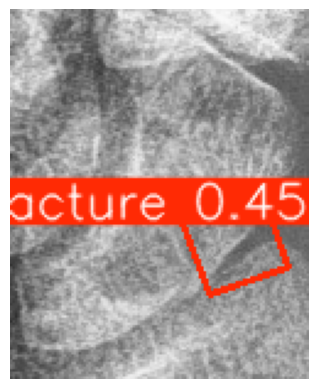

[70.93205261230469, 113.50852966308594, 76.11123657226562, 116.78985595703125]


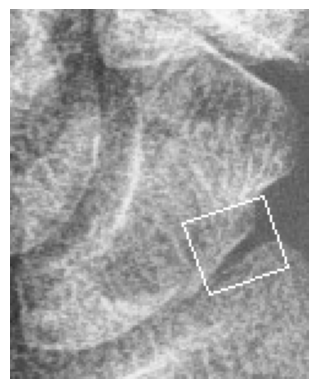

In [ ]:
from ultralytics import YOLO
from matplotlib.patches import Polygon
import os

model = YOLO("./best.pt")
file_path = "/content/gdrive/MyDrive/image_processing/part2/images/"
img=Image.open("/content/drive/MyDrive/image_processing/part2/images/00075616-AP0.jpg")
results = model(img, conf=0.25)  # Predict on an image

img = np.array(img)
for result in results:  # 遍歷每張影像的檢測結果
  if result.obb is not None and len(result.obb) > 0:  # 檢查是否有檢測結果
    print(f"Detections for image:")
    print(result.obb)  # 列印檢測結果
    img_with_detections = result.plot()

    # 將繪製的圖像顯示出來
    plt.imshow(img_with_detections)
    plt.axis("off")  # 隱藏坐標軸
    plt.show()
  else:
      print(f"No detections for image.")

  pre_box_ori=result.obb.xyxy[0].tolist()
  x_min, y_min, x_max, y_max = pre_box_ori  # 分別取出座標
  pre_box = [x_min, x_max, y_min, y_max]
  print(pre_box)

  for box in result.obb.xyxyxyxy:  # 迭代每个检测框的多边形
      # 转换为 NumPy 数组并调整形状
      points = np.array(box.tolist(), dtype=np.int32).reshape((-1, 1, 2))

      # 使用 cv2.polylines 绘制封闭的多边形
      cv2.polylines(img, [points], isClosed=True, color=(255,255, 255), thickness=1)

  # 使用 Matplotlib 显示图像
  plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))  # 转换为 RGB 格式以供显示
  plt.axis("off")  # 隐藏坐标轴
  plt.show()




In [ ]:
!zip -r /content/gdrive/MyDrive/image_processing/part2/model_ver6.zip /content/runs/obb/train4

  adding: content/runs/obb/train4/ (stored 0%)
  adding: content/runs/obb/train4/events.out.tfevents.1736315524.a7919a112261.528.3 (deflated 87%)
  adding: content/runs/obb/train4/confusion_matrix_normalized.png (deflated 37%)
  adding: content/runs/obb/train4/train_batch2.jpg (deflated 15%)
  adding: content/runs/obb/train4/labels_correlogram.jpg (deflated 50%)
  adding: content/runs/obb/train4/train_batch15010.jpg (deflated 39%)
  adding: content/runs/obb/train4/val_batch0_pred.jpg (deflated 24%)
  adding: content/runs/obb/train4/train_batch15012.jpg (deflated 26%)
  adding: content/runs/obb/train4/val_batch2_pred.jpg (deflated 18%)
  adding: content/runs/obb/train4/results.csv (deflated 61%)
  adding: content/runs/obb/train4/train_batch0.jpg (deflated 13%)
  adding: content/runs/obb/train4/args.yaml (deflated 52%)
  adding: content/runs/obb/train4/R_curve.png (deflated 22%)
  adding: content/runs/obb/train4/train_batch15011.jpg (deflated 39%)
  adding: content/runs/obb/train4/PR_cur